In [1]:
import numpy as np

save_path = '../CSF/Notebooks/'

import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd

In [3]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
isCD4 = (celllabels=='CD4')
clusters = np.load(save_path+'meta/CD4.clusters.npy')

In [4]:
def SignificanceDotPlot(fold_change, pvalue,names,colors,title,legend=False, ylim=5.5,jig=0.2):
    df = pd.DataFrame([fold_change, pvalue,names,colors[:len(names)]],index=['fold_change','pvalue','names','colors']).T
    df = df.sort_values('fold_change',ascending=True)
    rank = np.argsort(np.argsort(-fold_change))
    for index, row in df.iterrows():
        if row['pvalue']==0: row['pvalue']=1e-5
        plt.scatter(np.log10(row['fold_change']), -np.log10(row['pvalue']),edgecolors='gray',
                   color=row['colors'],
                  label = row['names'],s=200)
        if legend==True:
            plt.legend(bbox_to_anchor=(1.1, 0.5),loc='center left', borderaxespad=0, fontsize=5)
        if (-np.log10(row['pvalue'])>1):
            plt.text(np.log10(row['fold_change'])-jig, -np.log10(row['pvalue'])+jig, row['names'], color=row['colors'],fontsize=20)       
        if (np.log10(row['pvalue'])>1):
            plt.text(np.log10(row['fold_change'])-jig, -np.log10(row['pvalue'])+jig, row['names'], color=row['colors'],fontsize=20)      
    plt.ylim(-0.1,ylim)
    plt.axhline(y=1, color='b', linestyle='--')
    plt.axvline(x=0)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axhline(y=1.3, color='r', linestyle='--')
    plt.title(title,fontsize=30)


In [7]:
tissue=np.concatenate([np.repeat('CSF',8),np.repeat('PBMC',10)])
states=np.asarray(['MS','MS','MS','MS','control','control','control','control',
                   'MS','MS','MS','MS','MS','control','control','control','control','control'])


isMS = np.load(save_path+'meta/isMS.npy')[isCD4]
isCSF = np.load(save_path+'meta/isCSF.npy')[isCD4]
batchid = np.load(save_path+'meta/batchid.npy')[isCD4]

In [8]:

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [9]:
grouped_counts = []
for i in np.unique(clusters):
    count = np.asarray([
        np.sum((isMS*isCSF)[clusters==i]),
        np.sum(((isMS==False)*isCSF)[clusters==i]),
        np.sum((isMS*(isCSF==False))[clusters==i]),
        np.sum(((isMS==False)*(isCSF==False))[clusters==i]),
    ])
    grouped_counts.append(count)
    
grouped_counts = np.asarray(grouped_counts)
np.savetxt(save_path + 'count_test/CD4_louvain.grouped_count.txt',grouped_counts)

In [10]:
celltype_counts = []
for i in np.unique(clusters):
    count = np.asarray([np.sum((clusters==i)*(batchid==j))
        for j in np.unique(batchid)
    ])
    celltype_counts.append(count)
    
celltype_counts = np.asarray(celltype_counts)
np.savetxt(save_path + 'count_test/CD4_louvain.count.txt',celltype_counts)

In [11]:
celltype = np.unique(clusters).astype('str')

In [12]:
total = np.sum(celltype_counts,0)

In [13]:
from scipy.stats import ttest_ind

def Ttest(X,N,C):
    p = np.asarray([x/n for x,n in zip(X,N)])
    pvalue =  ttest_ind(p[C==True],p[C==False])[1]
    foldchange = np.sum((X[C==True]+1)/N[C==True]) / np.sum((X[C==False]+1)/N[C==False])
    lfc = np.log10(foldchange) 
    return [foldchange,pvalue]


In [14]:
CSFp = []
for i,k in enumerate(np.unique(clusters)):
    CSFp.append(Ttest(celltype_counts[i,:],
                      total,
                      tissue=='CSF'))

CSFp = np.asarray([x for x in CSFp])

CSFp_con = []
for i,k in enumerate(np.unique(clusters)):
    CSFp_con.append(Ttest(celltype_counts[i,states=='control'],
                      total[states=='control'],
                      tissue[states=='control']=='CSF'))

CSFp_con = np.asarray([x for x in CSFp_con])

MSp = []
for i,k in enumerate(np.unique(clusters)):
        MSp.append(Ttest(celltype_counts[i,:],
                         total,
                         states=='MS'))

MSp = np.asarray([x for x in MSp])

CSFMSp = []
for i,k in enumerate(np.unique(clusters)):
    CSFMSp.append(Ttest(celltype_counts[i,tissue=='CSF'],
                        total[tissue=='CSF'],
                        states[tissue=='CSF']=='MS'))

CSFMSp = np.asarray([x for x in CSFMSp])
   

PBMCMSp = []
for i,k in enumerate(np.unique(clusters)):
    PBMCMSp.append(Ttest(celltype_counts[i,tissue!='CSF'],
                         total[tissue!='CSF'],
                         states[tissue!='CSF']=='MS'))
    
PBMCMSp = np.asarray([x for x in PBMCMSp])


In [15]:
colors = ['#ff4040', '#d6a1a1', '#5c4545', '#d6a136', '#aaff00', '#bfffbf', '#2e5c4d', '#6bb3d6', '#0000ff', '#000033', '#6b6bd6', '#ad0074']
colors = np.asarray(colors)

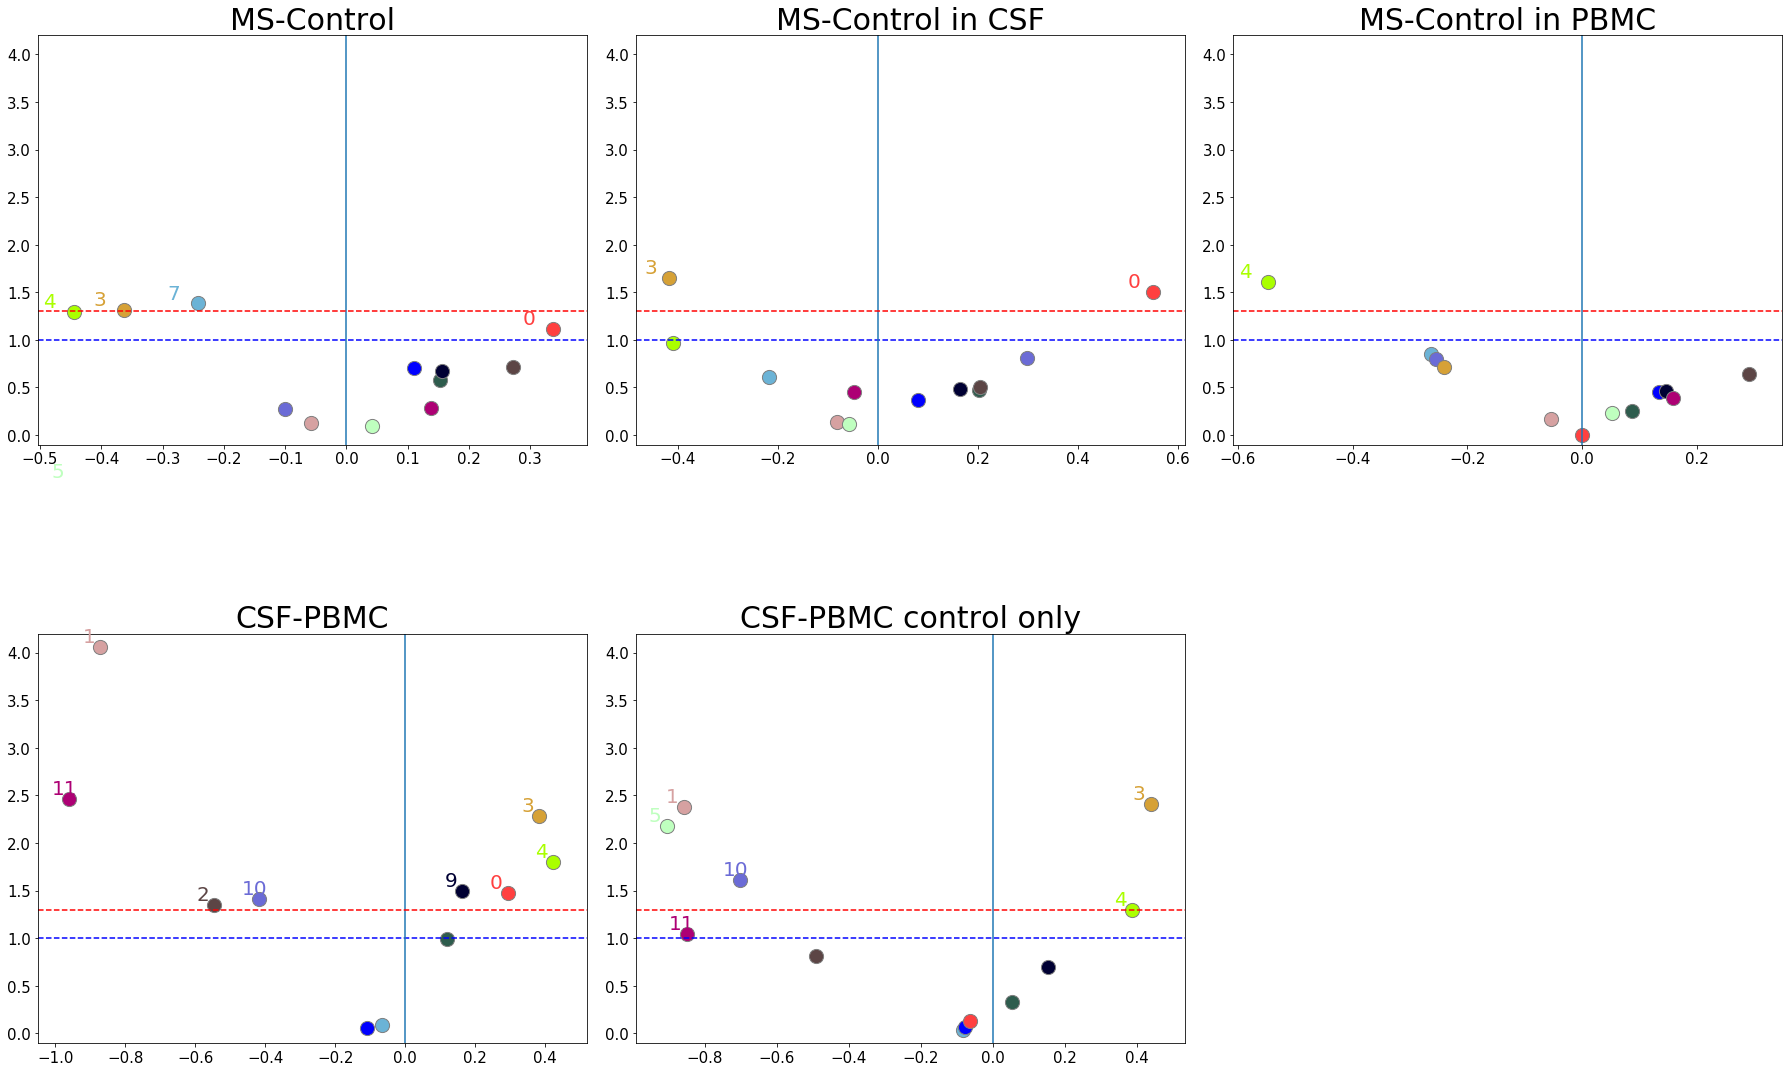

In [16]:
plt.figure(figsize=(25,15))
plt.subplot(2, 3, 1)
SignificanceDotPlot(MSp[:,0],MSp[:,1],celltype,colors,'MS-Control',ylim=4.2,jig=0.05)
plt.subplot(2, 3, 2)
SignificanceDotPlot(CSFMSp[:,0],CSFMSp[:,1],celltype,colors,'MS-Control in CSF',ylim=4.2,jig=0.05)
plt.subplot(2, 3, 3)
SignificanceDotPlot(PBMCMSp[:,0],PBMCMSp[:,1],celltype,colors,'MS-Control in PBMC',ylim=4.2,jig=0.05)
plt.subplot(2, 3, 4)
SignificanceDotPlot(CSFp[:,0],CSFp[:,1],celltype,colors,'CSF-PBMC',ylim=4.2,jig=0.05)
plt.subplot(2, 3, 5)
SignificanceDotPlot(CSFp_con[:,0],CSFp_con[:,1],celltype,colors,'CSF-PBMC control only',ylim=4.2,jig=0.05)
plt.tight_layout()
plt.savefig(save_path+'figures/CD4.Ttest.DiffProp.pdf')

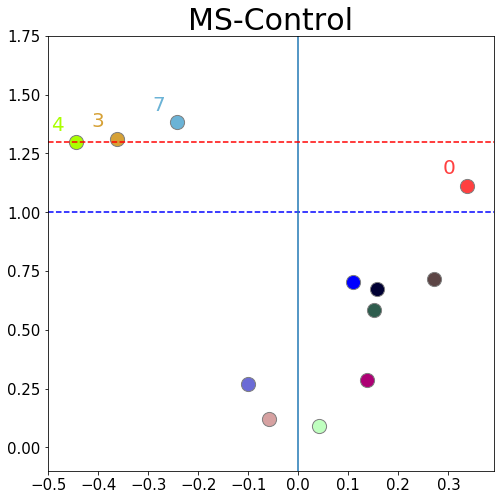

In [27]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(MSp[:,0],MSp[:,1],celltype,colors,'MS-Control',jig=0.05,ylim=1.75)
plt.savefig(save_path + 'figures/Figure3/CD4.Ttest_MSControl.pdf')

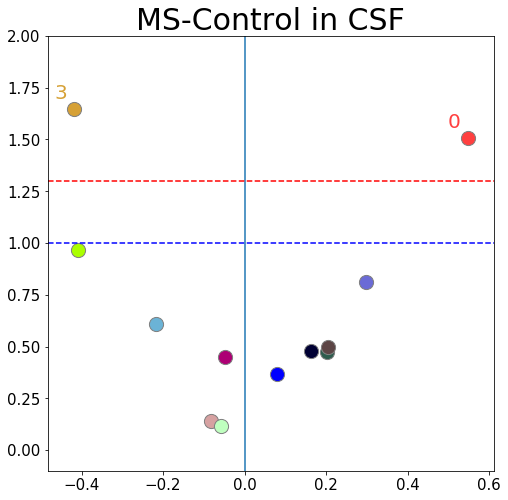

In [28]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFMSp[:,0],CSFMSp[:,1],celltype,colors,'MS-Control in CSF',jig=0.05,ylim=2)
plt.savefig(save_path + 'figures/Figure3/CD4.Ttest_MSControl_CSF.pdf')

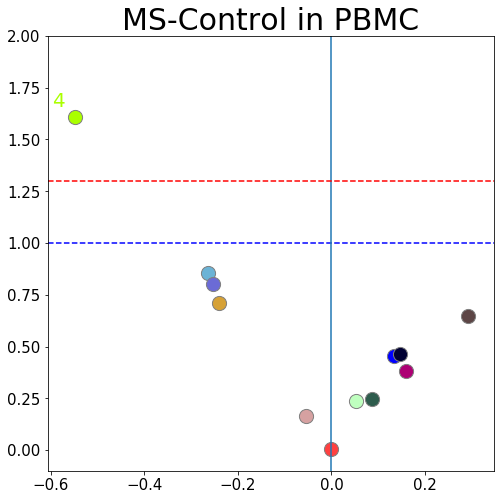

In [29]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(PBMCMSp[:,0],PBMCMSp[:,1],celltype,colors,'MS-Control in PBMC',jig=0.05,ylim=2)
plt.savefig(save_path + 'figures/Figure3/CD4.Ttest_MSControl_PBMC.pdf')

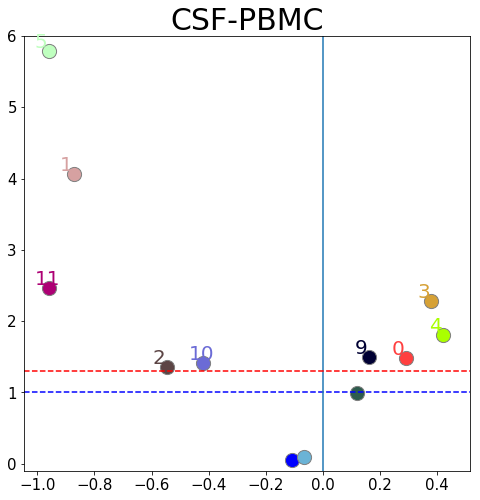

In [30]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp[:,0],CSFp[:,1],celltype,colors,'CSF-PBMC',jig=0.05,ylim=6)
plt.savefig(save_path + 'figures/Figure3/CD4.Ttest_CSFPBMC.pdf')

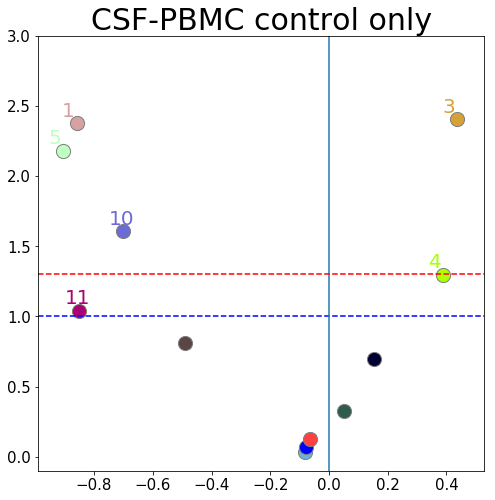

In [32]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp_con[:,0],CSFp_con[:,1],celltype,colors,'CSF-PBMC control only',jig=0.05,ylim=3)
plt.savefig(save_path + 'figures/Figure3/CD4.Ttest_CSFPBMC_control.pdf')

In [33]:
CSFp = np.genfromtxt(save_path+'count_test/CD4_louvain.betabinomreg.CSF.csv',delimiter=',')
CSFp_con = np.genfromtxt(save_path+'count_test/CD4_louvain.betabinomreg.CSF_control.csv',delimiter=',')
MSp = np.genfromtxt(save_path+'count_test/CD4_louvain.betabinomreg.MS.csv',delimiter=',')
CSFMSp = np.genfromtxt(save_path+'count_test/CD4_louvain.betabinomreg.CSFMS.csv',delimiter=',')
PBMCMSp = np.genfromtxt(save_path+'count_test/CD4_louvain.betabinomreg.PBMCMS.csv',delimiter=',')

/data/yosef2/users/chenling/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


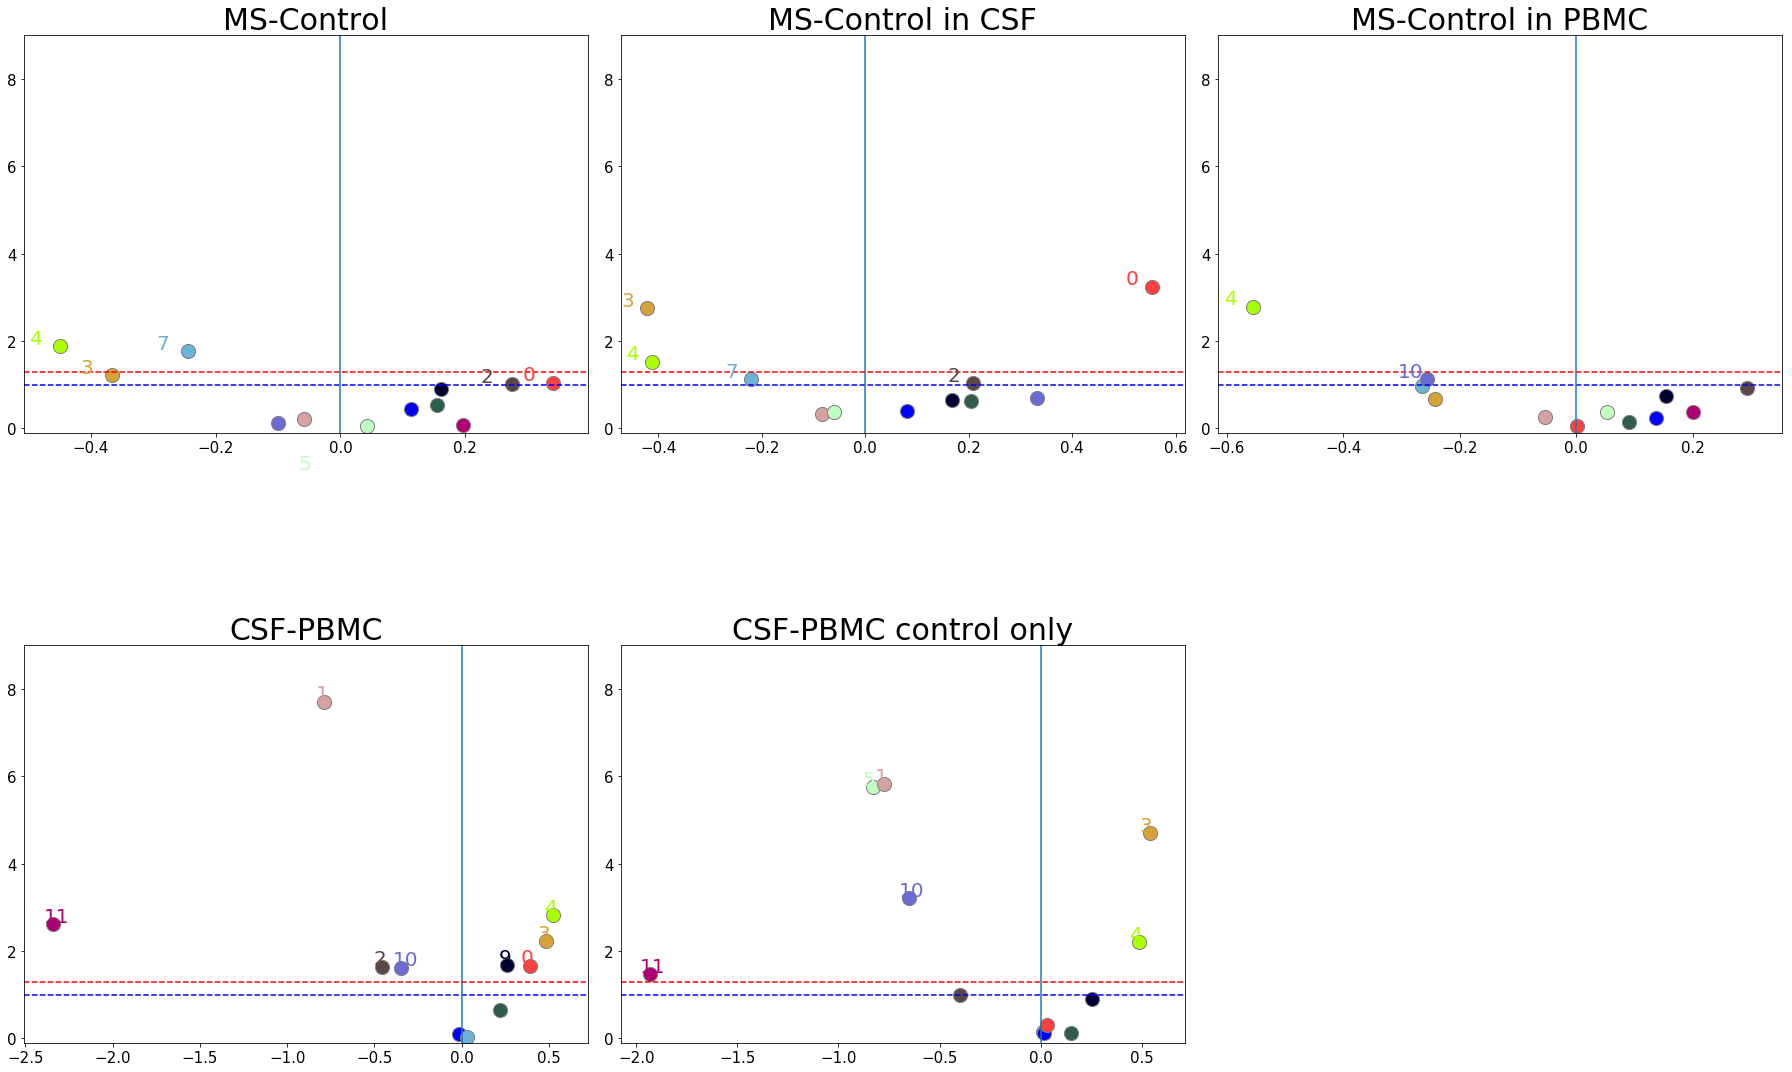

In [34]:
plt.figure(figsize=(25,15))
plt.subplot(2, 3, 1)
SignificanceDotPlot(MSp[:,1],MSp[:,0],celltype,colors,'MS-Control',ylim=9,jig=0.05)
plt.subplot(2, 3, 2)
SignificanceDotPlot(CSFMSp[:,1],CSFMSp[:,0],celltype,colors,'MS-Control in CSF',ylim=9,jig=0.05)
plt.subplot(2, 3, 3)
SignificanceDotPlot(PBMCMSp[:,1],PBMCMSp[:,0],celltype,colors,'MS-Control in PBMC',ylim=9,jig=0.05)
plt.subplot(2, 3, 4)
SignificanceDotPlot(CSFp[:,1],CSFp[:,0],celltype,colors,'CSF-PBMC',ylim=9,jig=0.05)
plt.subplot(2, 3, 5)
SignificanceDotPlot(CSFp_con[:,1],CSFp_con[:,0],celltype,colors,'CSF-PBMC control only',ylim=9,jig=0.05)
plt.tight_layout()
plt.savefig(save_path+'figures/CD4.BetaBinomial.DiffProp.pdf')

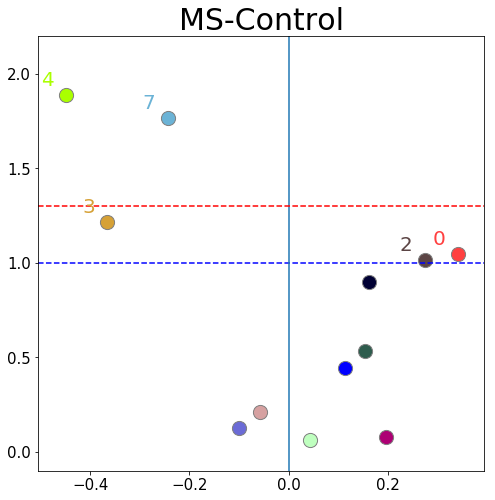

In [39]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(MSp[:,1],MSp[:,0],celltype,colors,'MS-Control',jig=0.05,ylim=2.2)
plt.savefig(save_path + 'figures/Figure3/CD4.BetaBinom_MSControl.pdf')

/data/yosef2/users/chenling/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


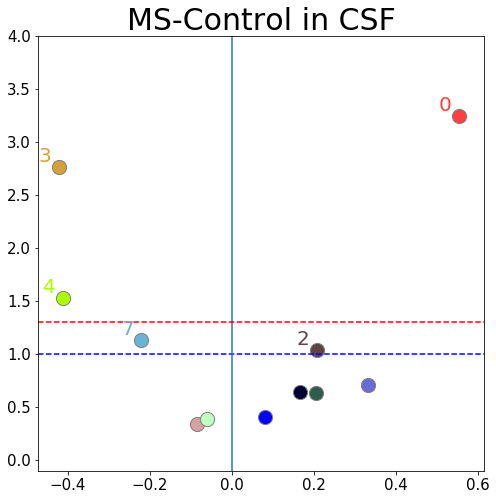

In [42]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFMSp[:,1],CSFMSp[:,0],celltype,colors,'MS-Control in CSF',jig=0.05,ylim=4)
plt.savefig(save_path + 'figures/Figure3/CD4.BetaBinom_MSControl_CSF.pdf')

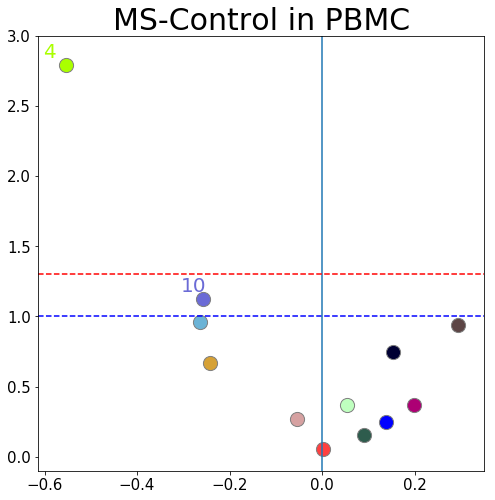

In [44]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(PBMCMSp[:,1],PBMCMSp[:,0],celltype,colors,'MS-Control in PBMC',jig=0.05,ylim=3)
plt.savefig(save_path + 'figures/Figure3/CD4.BetaBinom_MSControl_PBMC.pdf')

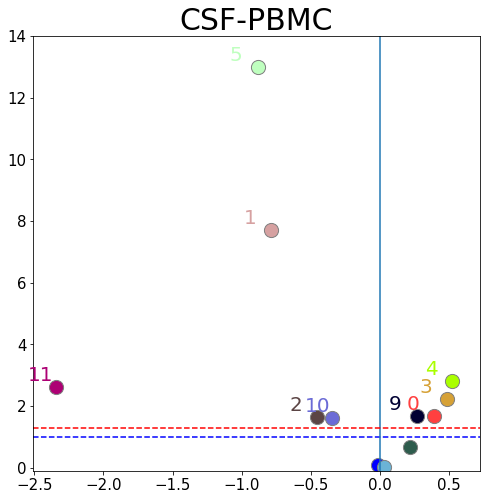

In [51]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp[:,1],CSFp[:,0],celltype,colors,'CSF-PBMC',jig=0.2,ylim=14)
plt.savefig(save_path + 'figures/Figure3/CD4.BetaBinom_CSFPBMC.pdf')

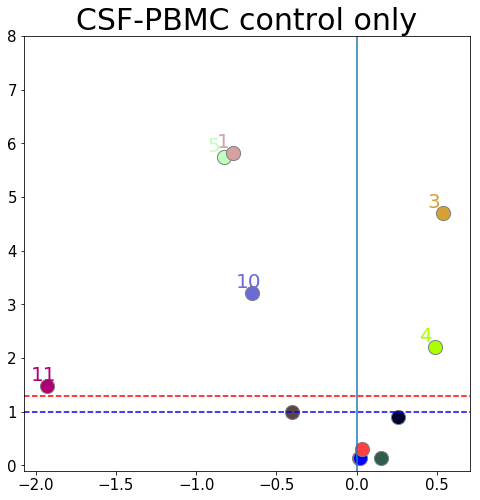

In [53]:
plt.figure(figsize=(8,8))
SignificanceDotPlot(CSFp_con[:,1],CSFp_con[:,0],celltype,colors,'CSF-PBMC control only',jig=0.1,ylim=8)
plt.savefig(save_path + 'figures/Figure3/CD4.BetaBinom_CSFPBMC_control.pdf')

In [22]:
def Heatmap(count,total,rankby,rownames,colnames,title,filename,width=9,height=8, save_path = save_path+'figures/'):
    freq=[]
    nfreq = []
    for i in range(len(count[0,:])):
        f = (count[:,i]+1)/total
        freq.append(f)
        nf = np.mean(f)
        nfreq.append(np.log10(f/nf))

    freq = np.asarray(freq)
    nfreq = np.asarray(nfreq)
    ranked = np.argsort(rankby)
    fig, ax = plt.subplots(figsize=(width,height))
    # We want to show all ticks...
    plt.imshow(nfreq[ranked,:],aspect='auto',cmap='bwr')
    plt.colorbar()
    ax.set_xticks(np.arange(len(rownames)))
    ax.set_yticks(np.arange(len(colnames)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(rownames,fontsize=20)
    ax.set_yticklabels(colnames[ranked],fontsize=20)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    print(count.shape,freq.shape,nfreq.shape,ranked.shape)
    for i in range(len(colnames)):
        for j in range(len(rownames)):
            text = ax.text(j, i, "{:.0f}".format(count.T[ranked,:][i,j]),
                           ha="center", va="center",fontsize=15)
    ax.set_title(title,fontsize=30)
    fig.tight_layout()
    plt.savefig(save_path + filename, transparency=True)



In [23]:
samplenames = [x+'_'+states[i] for i,x in enumerate(tissue)]
samplenames = np.asarray(samplenames)

(18, 12) (12, 18) (12, 18) (12,)


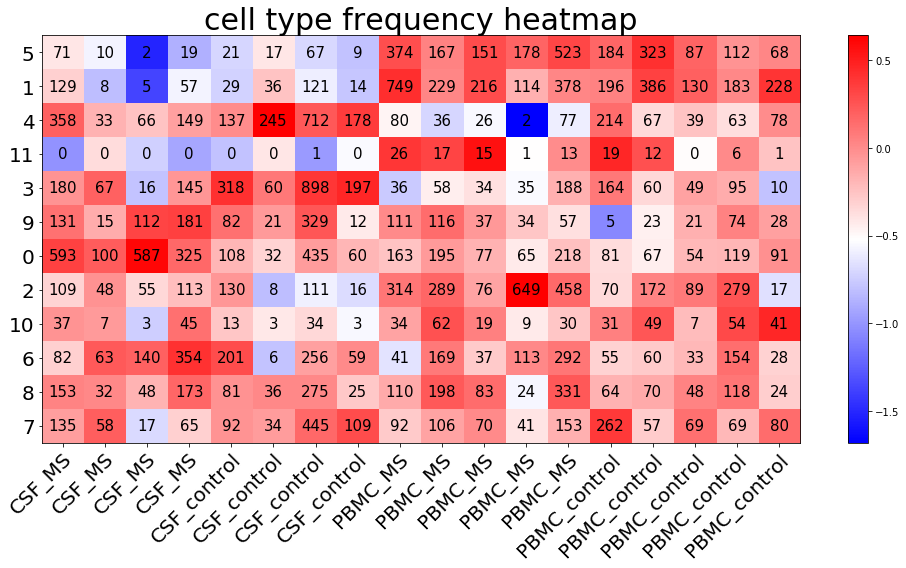

In [24]:
Heatmap(celltype_counts.T, total,CSFp[:,0], samplenames,celltype,'cell type frequency heatmap','CD4.freq.heatmap.pdf',width=14)


(8, 12) (12, 8) (12, 8) (12,)


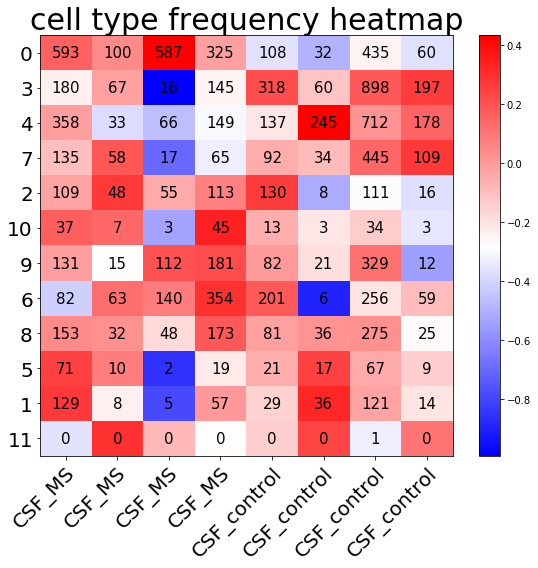

In [25]:
Heatmap(celltype_counts.T[tissue=='CSF',:], total[tissue=='CSF'],CSFMSp[:,0], samplenames[tissue=='CSF'],
        celltype,'cell type frequency heatmap','CD4.CSF.freq.heatmap.pdf',width=8)


(10, 12) (12, 10) (12, 10) (12,)


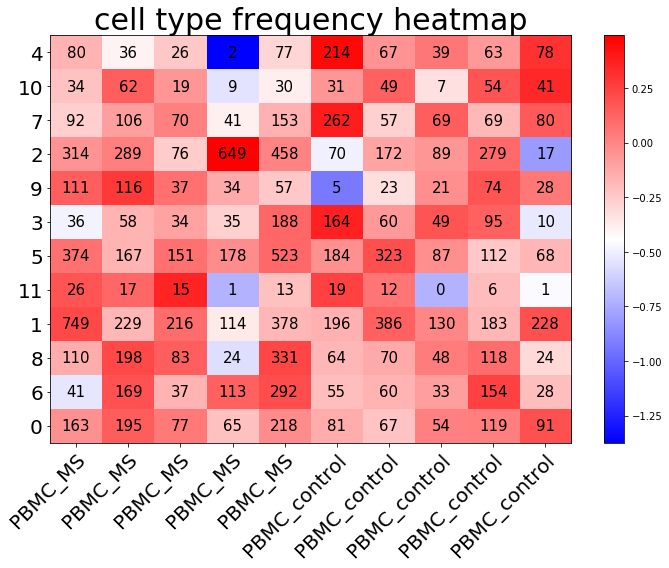

In [26]:
Heatmap(celltype_counts.T[tissue=='PBMC',:], total[tissue=='PBMC'],PBMCMSp[:,0], samplenames[tissue=='PBMC'],
        celltype,'cell type frequency heatmap','CD4.PBMC.freq.heatmap.pdf',width=10)


In [27]:
grouped_count= np.asarray([np.sum(celltype_counts.T[samplenames==name,:],axis=0) for name in np.unique(samplenames)])

In [28]:
grouped_total= np.asarray([np.sum(total[samplenames==name]) for name in np.unique(samplenames)])

(4, 12) (12, 4) (12, 4) (12,)


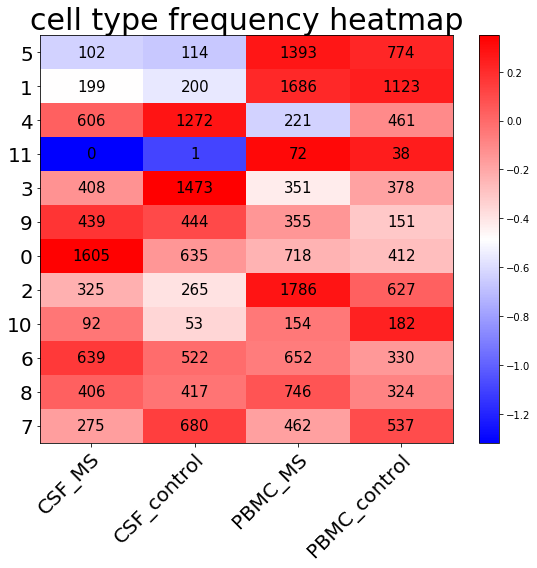

In [29]:
Heatmap(grouped_count, grouped_total,CSFp[:,0], np.unique(samplenames),
        celltype,'cell type frequency heatmap','CD4.grouped.freq.heatmap.pdf',width=8)